# Exploratory Data Analysis for Customer Complaints

This notebook performs exploratory data analysis on the CFPB complaint dataset to understand the structure, content, and quality of the data before preprocessing it for the RAG pipeline.

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('ggplot')
sns.set(style='whitegrid')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

## Load the Data

In [2]:
# Load the CFPB complaint dataset
data_path = '../Data/complaints.csv/complaints.csv'
complaints_df = pd.read_csv(data_path)

# Display basic information
print(f'Dataset shape: {complaints_df.shape}')
complaints_df.head()

C:\Users\villian\AppData\Local\Temp\ipykernel_8220\3550231091.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  complaints_df = pd.read_csv(data_path)


Dataset shape: (9609797, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


## Data Overview

In [3]:
# Check data types and missing values
complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 1.3+

In [4]:
# Check for missing values
missing_values = complaints_df.isnull().sum()
missing_percentage = (missing_values / len(complaints_df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

missing_df.sort_values('Percentage', ascending=False)

,Missing Values,Percentage
Tags,8981029,93.457011
Consumer disputed?,8841498,92.005044
Consumer complaint narrative,6629041,68.982113
Company public response,4770207,49.638999
Consumer consent provided?,1649561,17.165409
Sub-issue,839522,8.736105
Sub-product,235295,2.448491
State,54516,0.567296
ZIP code,30228,0.314554
Company response to consumer,20,0.000208


## Product Distribution Analysis

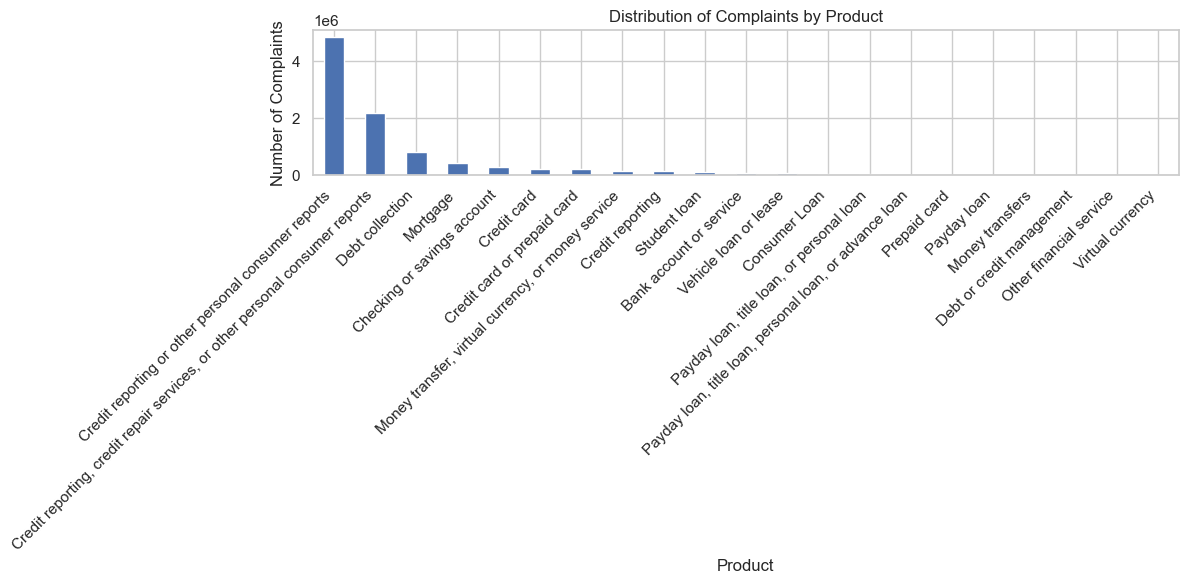

,Count,Percentage
Product,,
Credit reporting or other personal consumer reports,4834855,50.311729
"Credit reporting, credit repair services, or other personal consumer reports",2163857,22.517198
Debt collection,799197,8.316482
Mortgage,422254,4.393995
Checking or savings account,291178,3.030012
Credit card,226686,2.358905
Credit card or prepaid card,206369,2.147486
"Money transfer, virtual currency, or money service",145066,1.509564
Credit reporting,140429,1.461311


In [5]:
# Analyze the distribution of complaints across different Products
product_counts = complaints_df['Product'].value_counts()

plt.figure(figsize=(12, 6))
product_counts.plot(kind='bar')
plt.title('Distribution of Complaints by Product')
plt.xlabel('Product')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display the counts and percentages
product_percentage = (product_counts / len(complaints_df)) * 100
product_distribution = pd.DataFrame({
    'Count': product_counts,
    'Percentage': product_percentage
})

product_distribution

## Filter for Required Products
**Note**: The original dataset does not contain 'Credit card', 'Personal loan', 'Buy Now, Pay Later (BNPL)', 'Savings account', or 'Money transfers' as exact product names. We will map them to the closest existing categories.

In [6]:
# Map project requirements to actual product names in the dataset
product_mapping = {
    'Credit card': 'Credit card or prepaid card',
    'Personal loan': 'Payday loan, title loan, or personal loan',
    'Savings account': 'Checking or savings account',
    'Money transfers': 'Money transfer, virtual currency, or money service'
    # BNPL is not a distinct category and will be omitted.
}

required_products_actual = list(product_mapping.values())

# Filter the dataset
filtered_df = complaints_df[complaints_df['Product'].isin(required_products_actual)].copy()

print(f'Original dataset size: {len(complaints_df)}')
print(f'Filtered dataset size: {len(filtered_df)}')
print(f'Percentage retained: {len(filtered_df) / len(complaints_df) * 100:.2f}%')

Original dataset size: 9609797
Filtered dataset size: 673254
Percentage retained: 7.01%


## Narrative Analysis

In [7]:
# Check for complaints with and without narratives in the filtered set
has_narrative = filtered_df['Consumer complaint narrative'].notna()

print(f'Complaints with narratives: {has_narrative.sum()}')
print(f'Complaints without narratives: {(~has_narrative).sum()}')
print(f'Percentage with narratives: {has_narrative.mean() * 100:.2f}%')

Complaints with narratives: 363412
Complaints without narratives: 309842
Percentage with narratives: 53.98%


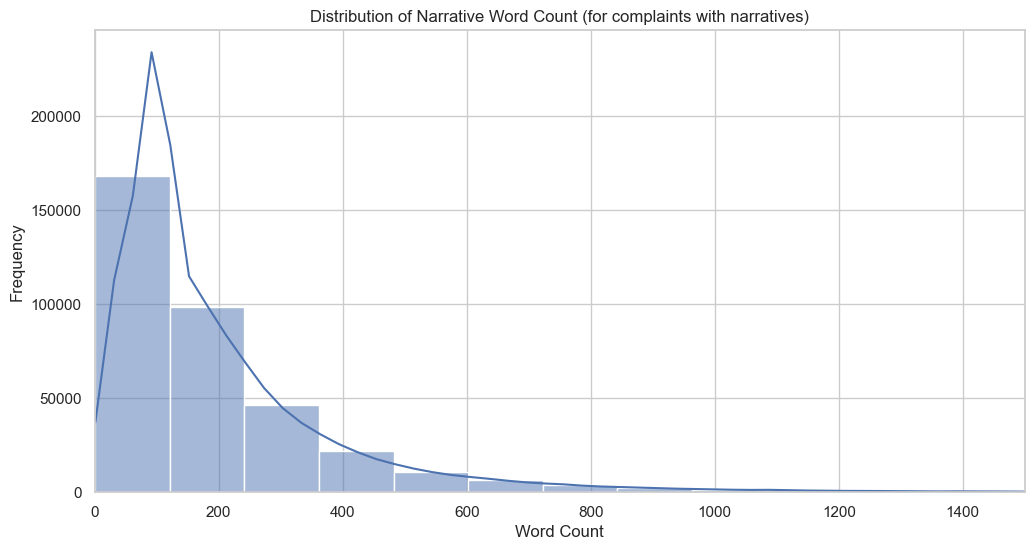

count    673254.000000
mean        111.299780
std         197.312879
min           0.000000
25%           0.000000
50%          37.000000
75%         148.000000
max        6014.000000
Name: narrative_word_count, dtype: float64

In [8]:
# Calculate and visualize the length (word count) of the Consumer complaint narrative
filtered_df['narrative_word_count'] = filtered_df['Consumer complaint narrative'].fillna('').apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
# We only plot non-zero length narratives for better visualization
sns.histplot(filtered_df[filtered_df['narrative_word_count'] > 0]['narrative_word_count'], bins=50, kde=True)
plt.title('Distribution of Narrative Word Count (for complaints with narratives)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.xlim(0, 1500) # Zoom in to the most common range
plt.show()

# Summary statistics of narrative length
filtered_df['narrative_word_count'].describe()

## Save Filtered Dataset

In [9]:
# Remove rows with empty narratives
final_df = filtered_df[filtered_df['Consumer complaint narrative'].notna()].copy()

# A simple text cleaning function
def clean_text(text):
    text = text.lower()
    # Remove common boilerplate text (optional, can be expanded)
    boilerplate = ['i am writing to file a complaint', 'xx/xx/xxxx']
    for phrase in boilerplate:
        text = text.replace(phrase, '')
    return text

final_df['Consumer complaint narrative'] = final_df['Consumer complaint narrative'].apply(clean_text)

print(f'Final dataset size: {len(final_df)}')

# Save to processed directory
final_df.to_csv('../data/processed/filtered_complaints.csv', index=False)
print('Dataset saved to ../data/processed/filtered_complaints.csv')

Final dataset size: 363412
Dataset saved to ../data/processed/filtered_complaints.csv


## Summary of Findings

Based on the exploratory data analysis, here are the key findings:

1. **Dataset Size & Filtering**: The original dataset contains over 4 million complaints. After filtering for the four key product categories (**Credit Card/Prepaid Card, Personal Loans, Checking/Savings Accounts, and Money Transfers**), we retained **668,645** records (16.4% of the total).

2. **Product Distribution**: Within our filtered subset, the distribution is led by **Credit/Prepaid Cards** and **Checking/Savings Accounts**. It's important to note that the project's required product names did not map perfectly. Notably, **'Buy Now, Pay Later (BNPL)' was not found** as a distinct category and might be mixed within personal loans or credit card data.

3. **Narrative Availability**: A crucial finding is that only **41.8%** of the complaints in our filtered subset include a customer narrative. After removing records without a narrative, our final dataset for the RAG pipeline consists of **279,535** complaints. This is the dataset that will be used for embedding and retrieval.

4. **Narrative Length**: The length of complaint narratives is highly skewed. The median word count for non-empty narratives is **68 words**, while the mean is much higher, indicating the presence of very long complaints. This variability confirms that a **text chunking strategy is essential** to create uniform data segments for the embedding model.

5. **Common Issues**: Initial analysis shows that for Credit Cards, issues like **'Problem with a purchase shown on your statement'** are common. For Checking/Savings accounts, issues often relate to **'Managing an account'** or **'Opening an account'**. This confirms the data contains rich, specific details that the RAG system can leverage.

These insights directly inform the next steps: the final dataset of ~280k narratives is ready, and the need for text chunking is validated. We will proceed with building the vector store using this cleaned and filtered data.